In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
import requests

In [76]:
url_1500 = 'https://en.wikipedia.org/wiki/1500_metres_world_record_progression'
resp_1500 = requests.get(url_1500)

# XML, HTML, and XPath

The eXtensible Markup Language (XML ) can represent all types of information, such as data sent to and from web services, including web pages, spreadsheets, visual displays like SVG, social network structures, word processing documents like MicroSoft's docx, databases, and much more. As a data scientist, knowing a little about XML can come in handy.

Despite its name, XML is not itself a language. Rather, it is a very general structure we can use to define formats to represent and organize data. XML provides a basic structure and syntax for these “dialects” or vocabularies. If you read or composed HTML (HyperText Markup Language), you will recognize the format of XML. 

The basic unit in XML is the *element*, which is also referred to as a *node*. An element has a name, and may have attributes, child elements, and text. The following annotated snippet of an XML plant catalog provides an example of these pieces. (This content is adapted from [W3 schools]( http://www.w3schools.com/XML/plant).)

```
<catalog>                                     The topmost node, aka root node.
    <plant>                                   The first child of the root node.
        <common>Bloodroot</common>            The common node is a child of this plant node.
        <botanical>Sanguinaria canadensis</botanical>
        <zone>4</zone>                        This zone node has text content: 4.
        <light>Mostly Shady</light>
        <price curr="USD">$2.44</price>       This node has an attribute, curr.
        <availability date="0399"/>           Empty nodes can collapse into one tag.
    </plant>                                  Nodes must be closed. 
    <plant>                                   This plant node is a sibling of the other one.
        <common>Columbine</common>
        <botanical>Aquilegia canadensis</botanical>
        <zone>3</zone>
        <light>Mostly Shady</light>
        <price curr="CAD">$9.37</price>
        <availability date="0199"/>
    </plant>
</catalog>
```

We added the indentation to this snippet to make it easier to see the structure.

XML Syntax
: XML documents are plain text files with the following syntax rules. 

+ Each element begins with a start-tag, like \<plant\>, and closes with an end-tag with of same name, like \</plant\>. 
+ XML elements can hold other XML elements. We call these child elements. 
+ XML elements can also be plain text, like "Columbine" in \<common\>Columbine\</common\>. 
+ XML elements can have optional attributes. These must be in the format: name="value". The element \<price curr="CAD"\> has an attribute named "curr" with a value of "CAD". 
+ In the special case when a node has no children, the end-tag can be folded into the start-tag. An example is the \<availability date="0199"\\\>. 

Well-formed XML
: We call an XML document well-formed when it follows certain rules. The most important of these are:

+ One root node contains all of the other elements in the document.
+ Elements nest properly, so that an open node closes around all of its children and no more. 
+ Tag names are case sensitive.
+ Attribute values have a name="value" format and the value is in single or double quotes.

There are additional rules that must be adhered to in order for a document to be well-formed. These relate to blank space, special characters, naming conventions, and repeated attributes.

The hierarchical nature of XML means it can be represented as a tree. The tree in {numref}`Figure %s <fig-xml-tree>` shows a tree representation of the plant catalog. 

```{figure} figures/plant-catalog-tree.png
---
name: fig-xml-tree
---

Hierarchy of an XML document. The lighter grey boxes represent text elements. By design these cannot have child nodes.  
```

Like with JSON, an XML document is plain text. We can read it with a plain-text viewer, and it's easy for machines to read and create XML content.  The extensible nature of XML allows content to be easily merged into higher-level container documents and easily exchanged with other applications. XML also supports binary data and arbitrary character sets.

As mentioned already, HTML looks a lot like XML. That's no accident, and indeed, XHTML is a subset of HTML that follows the rules of well-formed XML. Let's pick up the earlier example of the Wikipedia page that we retrieved from the Internet and show how to used XML tools to create a data frame from it. 

## Example: Scraping Race Times from Wikipedia 

Earlier in this chapter, we used an HTTP request to retrieve the HTML page from Wikipedia shown in {numref}`Figure %s <fig-wiki-1500>`. The contents of this page are in HTML, which is essentially an XML vocabulary.  We can use the hierarchical structure of the page and XML tools to access data in one of the tables and wrangle into a data frame. In particular, we are interested in the second table in the page, a portion of it appears in the screen shot in {numref}`Figure %s <fig-html-table>`.  

```{figure} figures/wiki-table-1500.jpg
---
name: fig-html-table
---

Screenshot of the second table in the web page that contains the data we want to extract.
```

Before we to work on this table, we provide a quick summary of what a simple  HTML table looks like. Below is the HTML for a table with a header and two rows of three columns. 

```
<table>
 <tbody>
  <tr>
   <th>A</th><th>B</th><th>C</th> 
  </tr>
  <tr>
   <td>1</td><td>2</td><td>3</td>
  </tr>
  <tr>
   <td>5</td><td>6</td><td>7</td>
  </tr>
 </tbody>
</table>
```

Notice how the table is laid out in rows with "tr" elements, and each cell in a row is a "td" element that contains the text to be displayed in the table. We want to locate the text content in the "td" elements of the second table.

Our first task is to create a tree structure from the content of the web page. To do this, we use the `lxml` library, which provides access to the C-library `libxml2` for handling XML content. We can parse the web page into a hierarchical structure with the `fromstring` functionality of the `lxml.html` module. (Recall that `resp_1500` contains the response from our request, and the page is in the body of the response.)

In [99]:
from lxml import html

tree_1500 = html.fromstring(res.content)

In [81]:
type(tree_1500)

lxml.html.HtmlElement

Now we can work with the document using its tree structure. We can find all the tables in the HTML document with the following search for "table" nodes. This search uses the XPath tool, which we soon describe, to search for table nodes anywhere in the document. 

In [102]:
tables = tree_1500.xpath('//table')
type(tables)

list

In [83]:
len(tables)

6

We found six tables in the document. If we examine the web page, including by looking at its HTML source via the browser, we can figure out that the second table in the document contains the IAF-era times. This is the table we want. The screenshot in {numref}`Figure %s <fig-html-table>` shows that the first column contains the race times, the third holds names, and the fourth has the dates of the races. We can extract each of these pieces of information in turn and wrangle them into shape.  

First we extract the text from "td" elements (the first, third, and fourth) in each row of the second table. We do this with the following XPath expressions. 

In [197]:
times = tree_1500.xpath('//table[2]/tbody/tr/td[1]/b/text()')
names = tree_1500.xpath('//table[2]/tbody/tr/td[3]/a/text()')
dates = tree_1500.xpath('//table[2]/tbody/tr/td[4]/text()')

In [198]:
type(times[0])

lxml.etree._ElementUnicodeResult

These return values behave like a list, but each value is an element of the tree. We can convert them to strings, calculate the number of seconds for each time, and transform the dates into timestamps.

In [188]:
def get_sec(time):
    """convert time into seconds."""
    time = str(time)
    time = time.replace("+","")
    m, s = time.split(':')
    return float(m) * 60 + float(s)

In [199]:
time_sec = [get_sec(rt) for rt in times]

name_str = [str(s) for s in names]

date_str = [str(s) for s in dates] 
race_year = pd.to_datetime(date_str, format='%Y-%m-%d\n').year

We next create the data frame we wanted.

In [200]:
men_1500 = pd.DataFrame({"race_time":time_sec, "athlete":name_str, 
                         "year":race_year})

men_1500

,race_time,athlete,year
0,235.80,Abel Kiviat,1912
1,234.70,John Zander,1917
2,232.60,Paavo Nurmi,1924
...,...,...,...
35,208.86,Noureddine Morceli,1992
36,207.37,Noureddine Morceli,1995
37,206.00,Hicham El Guerrouj,1998


And finally, we create a plot showing the progress in race times over the years.

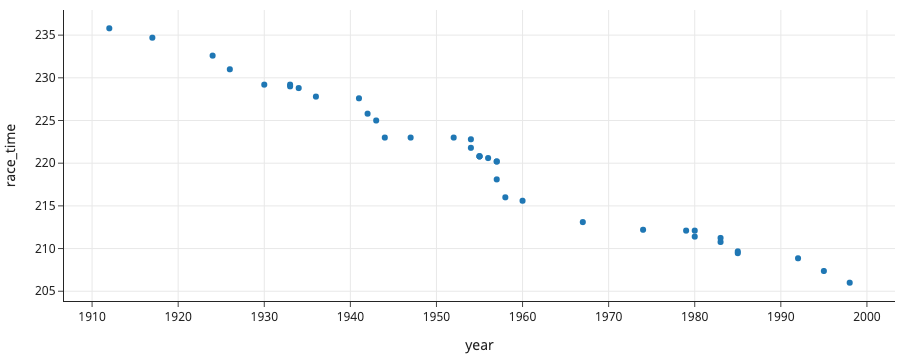

In [191]:
px.scatter(men_1500, x='year', y='race_time',
           width=450, height=250)

As you may have noticed, extracting data from an HTML page relies on careful examination of the source to find where in the document are the numbers that we're after. We relied heavily on the XPath tool to do the extraction. Its elegant language is quite powerful. We introduce it next.

## XPath

When we work with XML documents, we typically want to extract data from them and bring it into a data frame. XPath can help here. XPath can recursively traverse an XML tree to find the elements we want. For example, we used the expression '//table' in the previous example to locate all table nodes in our web page.  

XPath expressions operate on the hierarchy of a well-formed XML document. They are succinct and similar in format to the way files are located in a hierarchy of directories in a computer file system. But, they're much more powerful. XPath is also similar to regular expressions in that we specify patterns to match content. Like with regular expressions, it takes experience to compose correct XPath expressions.

An XPath expression forms logical steps to identify and filter nodes in a tree. The result is a *node-set* where each node occurs at most once. The node-set has an order that matches the order in which the nodes occur in the document, which can be quite handy.

Location Steps
: Each XPath expression is made up of one or more location steps, separated by a / character. An individual location step has three distinct parts, the axis, node-test, and an optional predicate.

+ The axis specifies the direction to look in, such as down, up or across the tree. We use the shortcuts for the axis exclusively. The default is to look down one step at children in the tree, the '//' that we have used already says to look down the tree as far as possible, and '..' indicates one step up to the parent of the active node. 
+ The node-test identifies the name or the type of node to look for. This is typically just a tag name for the nodes we're looking for or 'text()' for text elements. 
+ And a predicate acts like a filter to further restrict the node-set. These are given in square brackets, like `\[2\]` which evaluates to true if the node is the second in the node-set, and `\[ @date \]` which evaluates to true if the node has a date attribute. When the predicate is true, then the node remains in the node-set; if not, it is discarded. 

The shortcuts for the axis are very convenient; we leave it to the interested reader to learn more about the formal syntax.

We can tack together location steps to create powerful search instructions. {numref}`Table %s <xpath-examples>` provides several examples that cover the most common expressions. They all use short cuts when specifying the axis direction. Refer back to the tree in {numref}`Figure %s <fig-xml-tree>` to follow along. 

:::{table} XPath Examples
:name: xpath-examples

| Expression   | Result    |  Description                                                          |
|--------|---------|-------------------------------------------------------------------------------|
| '//common'   | two nodes | Look all down the tree for any common nodes. |
| '/catalog/plant/common'  | two nodes | Travel the specific path from the root node *catalog* to all plant nodes to all common nodes within the plant nodes. |
| '//common/text()'   | Bloodroot, Columbine  | Locate the text content of all common nodes. |
| '//plant\[2\]/price/text()'  | \$9.37 | Locate plant nodes anywhere in the tree, then filter to take only the second. From this plant node travel to its price child and locate its text. |
| '//@date'  | 0399, 0199 |  Locate the attribute value of any attribute named "date" in the tree.  |
| '//price[@curr="CAD"]/text()' | \$9.37 | The text content of any price node that has a currency attribute value of "CAD". |

:::


'//price[@curr="CAD"]/../common/text()' Columbine  

You can try out the XPath expressions in the table with the catalog file. We load the file into Python using the `etree` module since we are working with general XML. The `parse` method reads the file into an element tree. 

In [124]:
from lxml import etree

catalog = etree.parse('data/catalog.xml')

The 'lxml' library gives us access to XPath. Let's try it out.

Below is a simple XPath expression to locate all text content of a light node located anywhere in the tree.

In [148]:
catalog.xpath('//light/text()')

['Mostly Shady', 'Mostly Shady']

Notice that two elements are returned. Although the text content is identical, we have two unique nodes in our node-set and we are given the text content of each. The following expression is a bit more challenging.

In [193]:
catalog.xpath('//price[@curr="CAD"]/../common/text()')

['Columbine']

The expression locates all "price" nodes in the tree, then filters them according to whether their currency attribute is "CAD". Then for the remaining nodes (there's only one in this case), travel up one step in the tree to the parent node and then back down to any child "common" nodes and on to their text content. Quite the trip!

Next, we provide an example that uses an HTTP request to retrieve XML-formatted data, and then XPath to wrangle the content into a data frame. 

## Example: Accessing Exchange Rates from the ECB

The European Central Bank (ECB) makes exchange rates available online in an XML format.
Below is a snippet of recent data from their site. Let's begin by getting the most recent exchange rates from the ECB with an HTTP request.  

In [150]:
url = 'https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist-90d.xml?d574942462c9e687c3235ce020466aae'
resECB = requests.get(url)

In [151]:
resECB.status_code

200

Again we can use the `lxml` library to parse the text document we received from the ECB, but this time the contents are in a string returned to us from the ECB, not a file. 

In [152]:
ecb_tree = etree.fromstring(resECB.content)

In order to extract the data we want, we need to know how it is organized.  Below is a snippet of the content. 

```
<gesmes:Envelope xmlns:gesmes="http://www.gesmes.org/xml/2002-08-01"
        xmlns="http://www.ecb.int/vocabulary/2002-08-01/eurofxref">
<gesmes:subject>Reference rates</gesmes:subject>
<gesmes:Sender>
<gesmes:name>European Central Bank</gesmes:name>
</gesmes:Sender>
<Cube>
<Cube time="2023-02-24">
<Cube currency="USD" rate="1.057"/>
<Cube currency="JPY" rate="143.55"/>
<Cube currency="BGN" rate="1.9558"/>
</Cube>
<Cube time="2023-02-23">
<Cube currency="USD" rate="1.0616"/>
<Cube currency="JPY" rate="143.32"/>
<Cube currency="BGN" rate="1.9558"/>
</Cube>
</Cube>
</gesmes:Envelope>
```

This document appears quite different in structure from the plant catalog. The snippet shows three levels of tags all with the same name, and none have text content. All of the relevant information is contained in attribute values. 

One parent "Cube" holds all of the others. The next layer of "Cube" elements pertain to the date; there is one "Cube" element for each day with a time attribute to specify the date. Within each of these time Cubes are more Cubes, one for each currency (US dollar, Japanese yen, Bulgarian lev). These innermost Cubes provide the name of the currency and the exchange rate in their attributes.  Another new feature are the terms "xmlns" in the root "Envelope" node, and the odd tag-names like "gesmes:Envelope".  These have to do with namespaces.

Namespaces
: XML allows content creators to use their own vocabularies. The namespace gives the rules for a vocabulary, such as allowable tag names and attribute names, and restrictions on how nodes can be nested. And, XML documents can merge vocabularies from different applications. To keep it all straight, information about the namespace(s) that are being used are provided in the document. 

The root node in the ECB file is "Envelope". The additional "gesmes:" in the tag-name indicates that the tags belong to the gesmes vocabulary, which is an international standard for the exchange of time series information.  In addition to the gesmes, another namespace is listed in the Envelope. It is the default namespace for the ECB vocabulary. We can tell because it doesn't have a prefix, like "gesmes:". Whenever a namespace is not provided in a tag-name, the default is used.

The upshot of this is that we need take into account these namespaces when we search for nodes. Let's see how this works when we extract the dates. From the snippet, we see that the dates reside in "time" attributes in some of thee Cube elements. Knowing that all of them are children of the top Cube, we can give a very specific XPath expression to step from the root to its Cube node and on to the children Cube nodes.

In [194]:
namespaceURI = 'http://www.ecb.int/vocabulary/2002-08-01/eurofxref'

date = ecb_tree.xpath('./x:Cube/x:Cube/@time', namespaces = {'x':namespaceURI})
date[:5]

['2023-02-24', '2023-02-23', '2023-02-22', '2023-02-21', '2023-02-20']

The `.` in the expression is a shortcut to signify "from here" and since we're at the top of the tree, in this case it's equivalent to "from the root". We specified the namespace in our expression as "x:". Even though, the e Cube nodes are using the default namespace, we must specify it in our XPath expression. Fortunately, we can simply pass in the namespace as a parameter with our own label ("x" in this case) and then include it in our tag-names.

Like with the HTML table, we can convert the date values into strings and from strings into timestamps.

In [195]:
date_str = [str(s) for s in date]
timestamps = pd.to_datetime(date_str, infer_datetime_format=True)

Now on to the exchange rates. They also appear in <Cube> nodes, ones that have a "rate" attribute. We can access all exchange rates in our document for the British pound with the following XPath expression:

'//Cube[@currency = "GBP"]/@rate'
    
This expression says: look for all Cube nodes anywhere in the document, filter them according to whether the node has a currency attribute value of "GBP", and return their rate attribute values.

Since we want to extract exchange rates for multiple currencies, we generalize the XPath expression. We also want to convert the exchange rates to a numeric storage type, and make them relative to the first day's rate so the different currencies are on the same scale, which makes them more amenable for plots. 

In [166]:
currs = ['GBP', 'USD', 'CAD']

xrates = pd.DataFrame({"date":timestamp}) 

In [167]:
for ctry in currs:
    expr = './/x:Cube[@currency = "' + ctry + '"]/@rate'
    rates = root.xpath(expr, namespaces = {'x':namespaceURI})
    rates_num = [float(rate) for rate in rates]
    first = rates_num[len(rates_num)-1]
    xrates[ctry] = [rate / first for rate in rates_num]
    

In [169]:
xrates.head()

,date,GBP,USD,CAD
0,2023-02-24,1.02,1.01,1.02
1,2023-02-23,1.02,1.01,1.02
2,2023-02-22,1.02,1.02,1.02
3,2023-02-21,1.02,1.02,1.02
4,2023-02-20,1.02,1.02,1.02


We wrap up this example with line plots of the exchange rates.

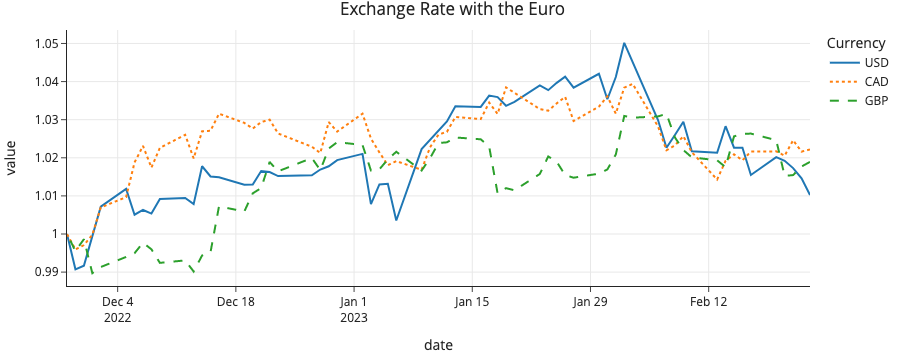

In [196]:
fig = px.line(xrates, x='date', y=["USD", "CAD", "GBP"],
             line_dash='variable',
             title="Exchange Rate with the Euro", 
             width=650, height=300)

fig.update_layout(legend_title_text='Currency', margin=dict(t=30))         
fig.show()